# ML Models

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [53]:
data = pd.read_csv("../data/fetal_health_mod.csv")
data.head()

,baseline value,accelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,histogram_width,histogram_median,histogram_variance,fetal_health
0,120.0,0.000,73.0,0.5,43.0,64.0,121.0,73.0,2.0
1,132.0,0.006,17.0,2.1,0.0,130.0,140.0,12.0,1.0
2,133.0,0.003,16.0,2.1,0.0,130.0,138.0,13.0,1.0
3,134.0,0.003,16.0,2.4,0.0,117.0,137.0,13.0,1.0
4,132.0,0.007,16.0,2.4,0.0,117.0,138.0,11.0,1.0


## Prepare data

In [54]:
x = data.drop('fetal_health', axis=1)
y = data['fetal_health']
x.shape, y.shape

((2126, 8), (2126,))

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2311)

In [56]:
baseline_acc = data['fetal_health'].value_counts().max()/data['fetal_health'].value_counts().sum()
print(f"Baseline accuracy: {baseline_acc:.2}")

Baseline accuracy: 0.78


In [20]:
def get_report(y_pred, y_test):
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}", )

## Decision Tree

In [49]:
dt_model = DecisionTreeClassifier(random_state=2311)
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [5, 10, 20, 40],
    'min_samples_leaf': [10, 20, 40],
    'max_features': [None, 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=0)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2311),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 8, 16, 32],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [10, 20, 40],
                         'min_samples_split': [5, 10, 20, 40],
                         'splitter': ['best', 'random']},
             scoring='f1_weighted')

In [50]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_dt_model = grid_search.best_estimator_
y_pred = best_dt_model.predict(x_test)
get_report(y_pred, y_test)

Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'best'}
Accuracy: 0.9249
Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       334
         2.0       0.73      0.81      0.77        57
         3.0       0.91      0.89      0.90        35

    accuracy                           0.92       426
   macro avg       0.87      0.88      0.87       426
weighted avg       0.93      0.92      0.93       426



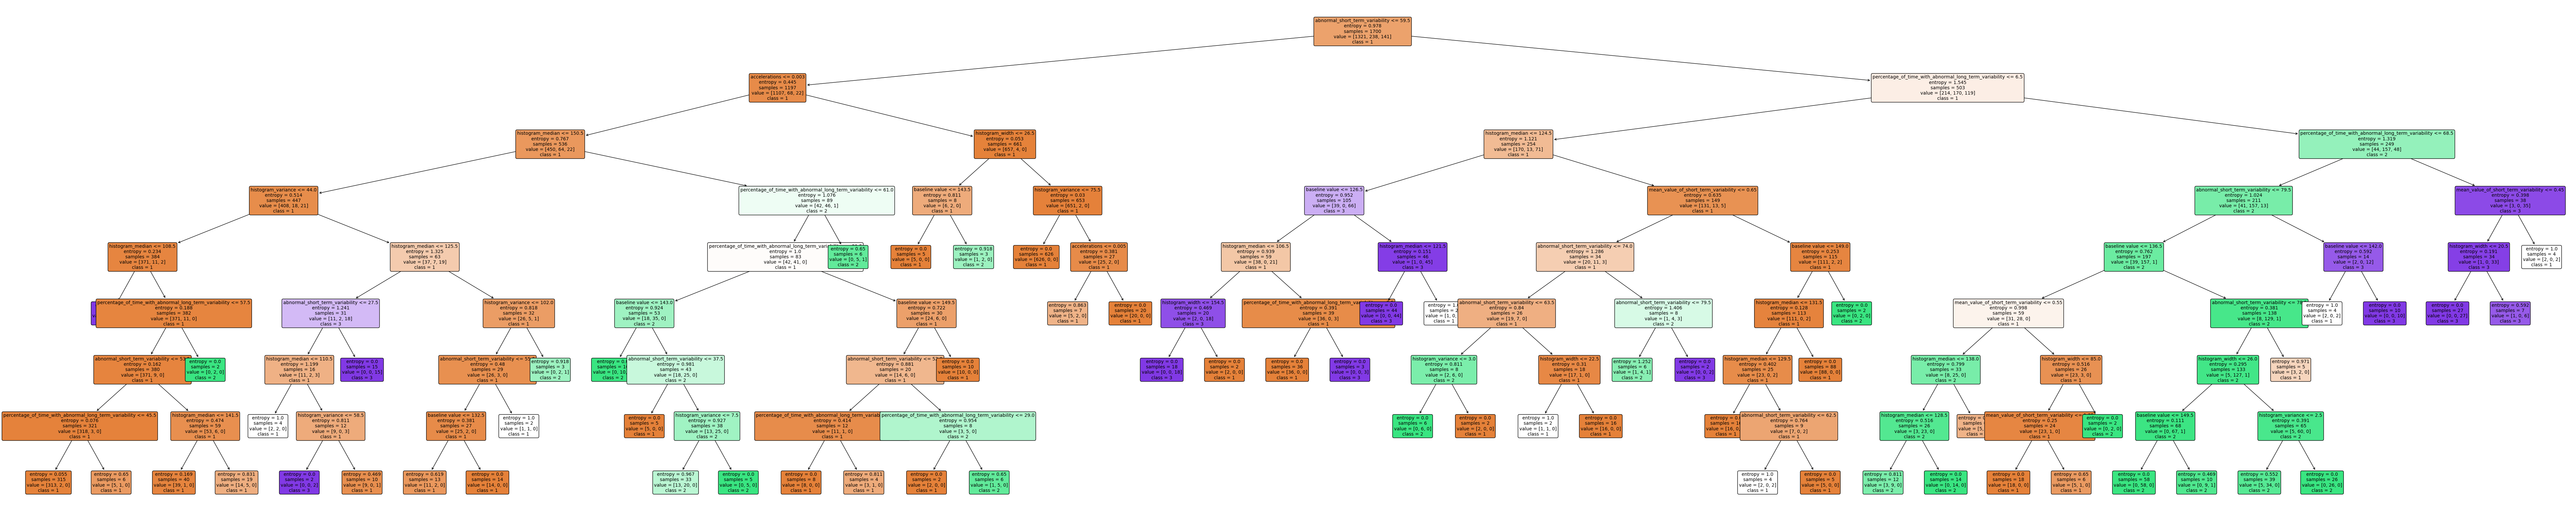

In [48]:
plt.figure(figsize=(100,20))
plot_tree(best_dt_model, 
          feature_names=list(x.columns),
          class_names=["1","2","3"],
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.savefig("../images/dt.png")
plt.show()

### Approach:
- Starting with the default decision tree, the result was very good. Accuracy, precision and recall were 0.8-0.9 for all 3 classes. But, as I plotted the tree, I noticed it was very deep. More than 10-15 layers meant it was incredibly complicated. This likely is evidence of overfitting. Since there is no max_depth parameter initially, the tree kept splitting by different features, and ended up classifying very narrowly.
- Therefore, I experimented with changing the hyper-parameters such as max_depth, splitter, and min_samples_split.
- I decided to go with GridSearchCV to save time in finding the best hyper-parameters. This way, I can try multiple combinations and see which produces the best results. Also, I can choose which hyper-parameters to try, which will prevent underfitting and overfitting. 

### Results:
With GridSearchCV helping find the best hyper-parameters, I got the following parameters as the optimal:

`Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'best'}`

The scoring metrics I used were accuracy, precision, recall, and F1. The results were very high and showed the model was learning from the training data. At the same time, due to the hyper-parameters, I also know that the model is not overfitting or underfitting.


## Random Forest

In [71]:
rf = RandomForestClassifier(random_state=2311)
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 20],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [10, 20, 40],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='f1_weighted')

In [72]:
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [73]:
y_pred = best_rf_model.predict(x_test)
get_report(y_pred, y_test)

Accuracy: 0.9437
Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.97       334
         2.0       0.82      0.79      0.80        57
         3.0       0.97      0.91      0.94        35

    accuracy                           0.94       426
   macro avg       0.92      0.89      0.90       426
weighted avg       0.94      0.94      0.94       426



### Approach
- Random Forest is an ensemble method that uses multiple decision trees on different subsets of the data and features.
- The goal is to produce better results (in terms of accuracy, precision and recall) while reducing overfitting. The complexity of the model should not be significantly more than the single decision tree model, but the predictive accuracy should be improved.
- For my initial run, training time was slightly over a minute. I started with n_estimators = 5, 10, 100, because I wanted to try a variety, while also knowing that a large number of estimators like 100 would likely lead better results. Other hyper-parameters were similar to those found in single decision tree. This resulted in macro avg of 0.92 for precision, 0.89 for recall and 0.9 for f1-score. The accuracy was 0.94. This is a step up from the single decision tree.
- One thing I noticed in this GridSearch is that the best value for n_estimators was 100. So, I wanted to test out larger values for n_estimators and see if they yielded better results.
- When adding values 200 and 400 to n_estimators, the best predictor still turned out to be 100.

### Results
With GridSearchCV helping find the best hyper-parameters, I got the following parameters as the optimal:

`Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}`

The results were very high and showed the model was learning from the training data. At the same time, due to the hyper-parameters, I also know that the model is not overfitting or underfitting.

This model performed better than single decision tree model due to the fact that random forest builts multiple trees on different subset of features and data, so it learns different patterns when splitting the data. Also, it produces better results since it aggregates the predictions of multiple trees, so it takes the best of all trees it makes.